<a href="https://colab.research.google.com/github/jcmachicao/pucp_energy_efficiency_AI/blob/main/02_NeuralNetworks/hvac_data_03_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
import torch
import torch.nn as nn

In [4]:
# Define the neural network (architecture)
class SimpleRegressionNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRegressionNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 4)
        self.fc4 = nn.Linear(4, output_size)
        self.relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [6]:
# Hyperparameters
input_size = 6
hidden_size = 64
output_size = 1

In [8]:
# To load the model later:
model_nn = SimpleRegressionNet(input_size, hidden_size, output_size)
path_model = 'drive/My Drive/00 data/'
model_nn.load_state_dict(torch.load(path_model + 'model_nn.pth'))
model_nn.eval() # Set the model to evaluation mode

<ipython-input-8-973c00fe19a0>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_nn.load_state_dict(torch.load(path_model + 'model_nn.pth'))


SimpleRegressionNet(
  (fc1): Linear(in_features=6, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=1, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
)

In [9]:
# Replace with the actual URL of your CSV file
url = 'https://github.com/jcmachicao/pucp_energy_efficiency_AI/raw/refs/heads/main/00_data/HVAC_dataset.xlsx'
data = pd.read_excel(url)
data.head(2)

,Date,on_off,damper,active_energy,co2_1,amb_humid_1,active_power,pot_gen,high_pressure_1,high_pressure_2,low_pressure_1,low_pressure_2,high_pressure_3,low_pressure_3,outside_temp,outlet_temp,inlet_temp,summer_setpoint_temp,winter_setpoint_temp,amb_temp_2
0,2022-01-06 00:00:00,0.0,0.0,363150.69,975.0,35.0,0.36,4.0,15.09,15.0,15.27,15.1,15.2,15.2,23.4,24.2,22.8,22.5,18.0,23.4
1,2022-01-06 00:05:00,0.0,0.0,NaN,977.0,35.0,0.36,NaN,15.03,14.9,15.21,15.0,15.2,15.1,23.3,24.2,22.7,22.5,18.0,23.3


In [10]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce', infer_datetime_format=True)
data.set_index('Date', inplace=True)

<ipython-input-10-cf9c410c4bfa>:1: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce', infer_datetime_format=True)


In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
df.index = data.index

In [14]:
from sklearn.model_selection import train_test_split
features_nn = ["inlet_temp", "outside_temp", "amb_humid_1", 'active_power', 'high_pressure_1', 'low_pressure_1']
output_variable_nn = 'co2_1'
target = output_variable_nn
X = df[features_nn]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19224, 6), (6408, 6), (19224,), (6408,))

In [15]:
validation_data = torch.tensor(X_test.values, dtype=torch.float32)
validation_labels = torch.tensor(y_test.values, dtype=torch.float32)

In [17]:
path_model = 'drive/My Drive/00 2024_all/data_2024/'
os.listdir(path_model)

['model_nn.pth']

In [20]:
!pip install -q captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.4 MB/s eta 0:00:00


In [21]:
from captum.attr import IntegratedGradients

In [23]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    model_nn.to(device)
    validation_data = validation_data.to(device)

ig = IntegratedGradients(model_nn)
attributions, delta = ig.attribute(validation_data, target=0, return_convergence_delta=True)
print(f"Attributions shape: {attributions.shape}")

# Example of how to analyze attributions
print(f"Attributions for the first sample:\n{attributions[0]}")

# Convert attributions back to CPU if needed
attributions = attributions.cpu().detach().numpy()
attributions.shape

Attributions shape: torch.Size([6408, 6])
Attributions for the first sample:
tensor([-4.6897e-03, -1.6675e-03,  3.5204e-02, -2.3646e-05,  2.4078e-03,
         1.0564e-02], dtype=torch.float64)


(6408, 6)

This code visualizes the feature importance for five specific samples using bar plots. Each bar's height represents the contribution of a particular feature to the model's prediction for that sample.

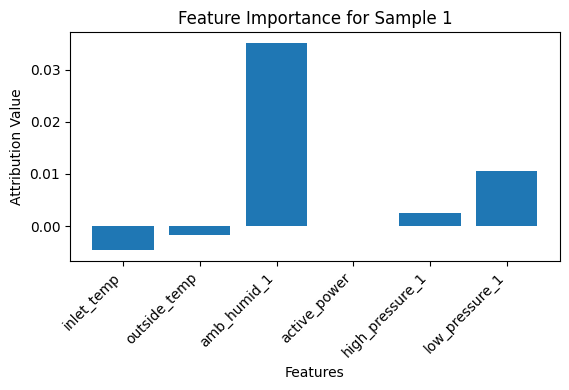

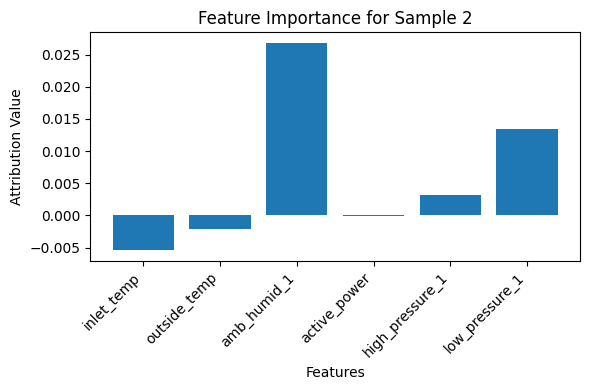

In [24]:
# Visualization (example using matplotlib)
import matplotlib.pyplot as plt
import numpy as np

feature_names = features_nn  # Replace with your actual feature names

for i in range(len(attributions[10:12])):
  plt.figure(figsize=(6, 4))
  plt.bar(feature_names, attributions[i])
  plt.xlabel("Features")
  plt.ylabel("Attribution Value")
  plt.title(f"Feature Importance for Sample {i+1}")
  plt.xticks(rotation=45, ha='right')
  plt.tight_layout()
  plt.show()

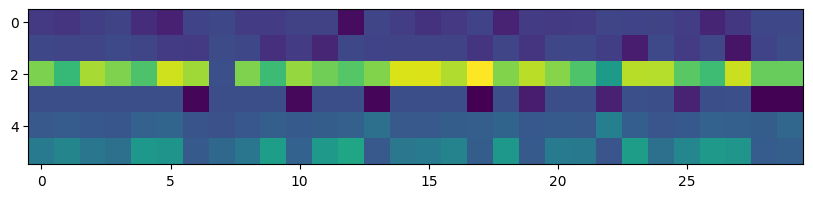

In [29]:
plt.figure(figsize=(10,4))
plt.imshow(attributions[0:30].T)